In [1]:
#Librerias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from numpy import sin , cos , pi

## Subrutinas

**1) subrutina de rotacion**

Denotamos la posicion de la casa blanca antes de la rotacion como $\ \vec{r}_{wh0}\ $ y despues de la rotacion como $\ \vec{r}_{wh}\ $. 

La rotación del vector $\vec{r}_{wh0}$ un angulo $\lambda$ transcurrido un tiempo $\Delta t$ viene dada por:
$$
\vec{r}_{wh}=R_z(\lambda)\ \vec{r}_{wh0} 
$$
La anti-rotación viene dada por:
$$
\vec{r}_{wh0}=R_z(-\lambda)\ \vec{r}_{wh} 
$$

In [2]:
#Angulo theta
def rotacion(A,t):

  #Angulo de rotacion en funcion del tiempo
  theta = 7.2722052e-5*t

  # Matriz de anti-rotacion al rededor del eje z
  Rz=np.array([ [ cos(theta)    , -sin(theta) , 0 ],
                [ sin(theta)    ,  cos(theta) , 0 ],
                [     0         ,      0      , 1 ]  ])
  
  # Vector A despues de la rotacion
  Ar = Rz @ A

  return Ar

**2) Subrutinas Newton Raphson**

Esta subrutina nos ayuda a calcular la raiz de la funcion $F(z)$ que usaremos para calcular las funciones de Lagrange $f$, $g$, $f'$ y $g'$

In [3]:
#Metodo de Newton Raphson
def NR(zp,F,dF):
  zold=zp
  tol=1e-8
  dz=abs(2*tol)

  while dz > tol:
    znew=zold-F(zold)/dF(zold)
    dz=abs(znew-zold)
    zold=znew

  return zold

**3) Subrutinas de transformacion de coordenadas**

* **3.1)** De coordenadas cartesianas a geocentricas
* **3.2)** De coordenadas geocentricas a cartesianas
* **3.3)** De cordenadas cartesianas a geodesicas

**3.1)** Subrutina de transformacion de coordenadas $(x,y,z) \rightarrow (\lambda,\psi)$

In [4]:
#Subrutina que transforma cartesianas a terrestres
def CT(B):

  x=B[0] ; y=B[1] ; z=B[-1]

  if z > 0 :
	  theta = math.atan( math.sqrt( x**2 + y**2 ) / z )

  if z < 0 :
	  theta = pi + math.atan( math.sqrt( x**2 + y**2 ) / z )


  #Calculo de la longitud

  if x > 0 and y > 0 :
	  phi = math.atan( y / x )

  if x > 0  and y < 0 :
	  phi = 2*pi + math.atan( y / x )

  if  x < 0 :
	  phi = pi + math.atan( y / x )


  if phi >= 0 and phi <= pi :
	  long = phi

  if phi > pi and phi < 2*pi :
	  long = phi - 2*pi

  #Calculo de la latitud
  lat = 0.5*pi - theta

  longitud = long* 180 / pi ; latitud = lat * 180 / pi

  return latitud,longitud

**3.2)** Subrutina que nos transforma $(\lambda,\psi) \rightarrow (x,y,z)$

In [5]:
def TC(phi,lam):
  Rt = 6.378
  lam=lam*pi/180 ; phi=phi*pi/180
  x  = Rt * cos(lam) * cos(phi)
  y  = Rt * sin(lam) * cos(phi)
  z  = Rt * sin(phi)
  vector = np.array([ x ,y ,z ])
  return vector 

**3.3)** Subrutina que transforma $(x,y,z)\rightarrow(\lambda,\varphi)$

In [6]:
def CG(A):
  #Semi eje mayor y menor
  a=6.3781370 ; b=6.3567523

  # -- Calculo de la longitud --
  x=A[0] ; y=A[1] ; z=A[2]

  # Primer cuadrante
  if x>0 and y>0: 
    longitud = math.atan( y / x )

  # Segundo y tercer cuadrante
  if x<0:
    longitud = math.atan( y / x ) + pi 

  # Cuarto cuadrante
  if x>0 and y<0:
    longitud = math.atan( y / x ) + 2*pi 

  phi = longitud

  if phi>=0 and phi<=pi:
	  longitud=phi

  if (phi>pi and phi<2*pi):
	  longitud=-2*pi+phi

  # -- Calculo de la latitud --

  e = (  1 - (b/a)**2  )**0.5
  eps = e**2 / ( 1 - e**2 ) 
  p = ( x**2 + y**2 )**0.5 ; q = math.atan(z*a/p/b)

  latitud = math.atan( (z+eps*b*sin(q)**3) / (p-e**2*a*cos(q)**3))

  # Subrutina que transforma coord's esfericas en terrestres

  
  latitud=latitud*180/pi
  longitud=longitud*180/pi

  latitud=round(latitud,6)
  longitud=round(longitud,6)
  return latitud, longitud

# Simulación 1 
## Problema Tierra - Meteorito
Un meteorito se dirige a la tierra, sus condiciones iniciales son:
$$
\vec{r}_0=(0.50000000,-6.5000000,4.5000000) \ [Mm]
$$
$$
\vec{v}_0=(0.00129281, -0.00141914,  0.00172849) \ [Mm/s]
$$

In [7]:
#Posicion inicial
r1=np.array([0.50000,-6.50000,4.50000])  ;  nr1=np.linalg.norm(r1)

#Velocidad inicial
v1=np.array([0.00129281, -0.00141914,  0.00172849]) ;  nv1=np.linalg.norm(v1)

# Tiempo de vuelo
dt=20*60

# Posicion inicial casa blanca
rwh0 = TC(38.897324, -77.036592)

**Calculo de los elementos orbitales**

In [8]:
#Calculo de los elementos orbitales
mu=3.98e-4

# Magnitud del momento angular
H=np.cross(r1,v1)
h=np.linalg.norm(H)

# Vector unitario k
k=np.array([0,0,1]) 

# Vector nodo
N=np.cross(k,H)
n=np.linalg.norm(N)

# Excentricidad
ex = np.cross(v1,H) / mu -  r1 / nr1
e=np.linalg.norm(ex)

# Vectores base en el sistema perifocal
xp=ex/e
zp=H/h
yp=np.cross(zp,xp)

# Semi-eje mayor "a"
p=h**2/mu
a=p/(1-e**2)

# Inclinación de la orbita "i"
i=math.acos(H[-1]/h )

# Longitud del nodo acendente
if N[1]>0:
  omega=math.acos(N[0]/n)  
if N[1]<0:
  omega=-math.acos(N[0]/n)

# Argumento del perigeo
if ex[-1]>0:
  w=math.acos( np.dot(N,ex) / (n*e) )
if ex[-1]<0:
  w=-math.acos( np.dot(N,ex) / (n*e) )

# theta0
prueba=np.dot(r1,v1)

if prueba > 0 :
  nu0=math.acos(np.dot(ex,r1)/(e*nr1))

if prueba < 0 : 
  nu0=-math.acos(np.dot(ex,r1)/(e*nr1))

#Vectores base del sistema perifocal
ip=ex/e ; kp=H/h ; jp=np.cross(kp,ip)

print('Los elementos orbitales son:')
print('-----------------------------')
print('h=',h)
print('a=',a)
print('e=',e)
print('Omega=',omega*180/np.pi,'°')
print('i=',i*180/np.pi,'°')
print('w=',w*180/np.pi,'°')
print('theta0=',nu0*180/np.pi,'°')

Los elementos orbitales son:
-----------------------------
h= 0.010355793002278966
a= 4.242475364015979
e= 0.9677224562277971
Omega= -135.60987806798033 °
i= 42.0178485342734 °
w= -118.49712878593924 °
theta0= 176.56563913105472 °


**Calculo de $\vec{r}_2$ y $\vec{v}_2$ usando variables universales - Parametrizacion de la orbita**

La ecuacion a resolver es
$$
\sqrt{\mu}\Delta t=\frac{\vec{r}_0\cdot\vec{v}_0}{\sqrt{\mu}}x^2\ C(\frac{x^2}{a})+x^{3}S(\frac{x^2}{a})+r_0x(1-zS(\frac{x^2}{a}))
$$
Para un dado valor de $\Delta t$ resolveremos para x usando Newton Raphson. 

Despues evaluaremos las funciones $f,g,\dot{f}$ y $\dot{g}$ dadas por las expresiones:
$$
f=1-\frac{x^2}{r_0}C(\alpha x^2) \ \ \ \ \ \ \ \ g=\Delta t - \frac{1}{\sqrt{\mu}}x^3S(\alpha x^2)
$$
$$
\dot{f}=\frac{\sqrt{\mu}}{rr_0}\Big[\alpha x^3 S(\alpha x^2) -x\Big] \ \ \ \ \ \ \ \ \ \dot{g}=1-\frac{x^2}{r}C(\alpha x^2)
$$


y con ellas calcularemos el estado siguiente $\vec{r}_{i+1}$ y $\vec{v}_{i+1}$ a partir del anterior

$$
\vec{r}_{i+1}=f\vec{r}_i+g\vec{v}_i
$$
.
$$
\vec{v}_{i+1}=\dot{f}\vec{r}_i+\dot{g}\vec{v}_i
$$

In [9]:
### DEFINIMOS LAS FUNCIONES S(z) Y C(z):

def fg2(a,r1,nr1,v1,mu):

    # Funcion S(z) 
  def S(x): 
    y=0
    for n in range(8):
      y+=(-1)**n*x**n/math.factorial(2*n+3)
    return y

  # Funcion C(z)
  def C(x):
    y=0
    for n in range(8):
      y+=(-1)**n * x**n /math.factorial(2*n+2)
    return y 

  # Coeficientes necesarios en la ecuacion trascendente
  alpha=1/a ; pp=np.dot(r1,v1) ; rmu=math.sqrt(mu) ; Dt=0.01

  F  = lambda x: np.dot(r1,v1)/math.sqrt(mu)*x**2*C(alpha*x**2)+(1-alpha*nr1)*x**3*S(alpha*x**2)+nr1*x-math.sqrt(mu)*Dt

  dF = lambda x: np.dot(r1,v1)/math.sqrt(mu)*x *(1-alpha*x**2*S(alpha*x**2))+(1-alpha*nr1)*x**2*C(alpha*x**2)+nr1
#___________________________________________________________________________________

  #Solucion de la ecuacion de Kepler mediante Newton-Raphson
  x0=math.sqrt(mu)*alpha*Dt
  xold=x0
  tol=1e-8
  dx=abs(2*tol)

  while dx > tol:
    xnew=xold-F(xold)/dF(xold)
    dx=abs(xnew-xold)
    xold=xnew
  xnew
#_________________________________________________________________________________

  #Calculo de f y g 
  f=1-xnew**2/nr1*C(alpha*xnew**2)
  g=Dt-xnew**3/math.sqrt(mu)*S(alpha*xnew**2)
  
  r2=r1*f+v1*g ; nr2=np.linalg.norm(r2)

  df=math.sqrt(mu)/nr1/nr2*(alpha*xnew**3*S(alpha*xnew**2)-xnew)
  dg=1-xnew**2/nr2*C(alpha*xnew**2)

  v2=df*r1+dg*v1 

  return r2,v2

**Se calcula la trayectoria con el método anterior mientras se cumpla la condición** $|\vec{r}|\geq R_{Earth}$

In [10]:
### CALCULO DE LA TRAYECTORIA

s=0 ; v=v1 ; r=r1 ; nr1 = np.linalg.norm(r1) 
Xg=[ r1[0] ] ; Yg=[ r1[1] ] ; Zg=[ r1[2] ]; T=[0]
Vxg=[v[0]] ; Vyg=[v[1]] ; Vzg=[v[2]]
cb=[rwh0] ; delta=[np.linalg.norm(rwh0-r)]

while nr1>=6.378:
    
  fg=fg2(a,r1,nr1,v1,mu)

  Xg.append(fg[0][0]) ; Vxg.append(fg[1][0])
  Yg.append(fg[0][1]) ; Vyg.append(fg[1][1])
  Zg.append(fg[0][2]) ; Vzg.append(fg[1][2])
    
  r1=fg[0] ; nr1=np.linalg.norm(r1)

  rwh=rotacion(rwh0,s) ; cb.append(rwh)
  
  delta.append(np.linalg.norm(rwh-r1))
  

  T.append(s) 
  v1=fg[1]
  s+=0.01

rg=np.array([Xg[-1],Yg[-1],Zg[-1]])


print('la posicion final es:')
print('rf =',r1,'Mm')
print('Profundidad del impacto:')
print('R = ',(6.378-nr1)*1e6,'Metros')
print('El tiempo de vuelo fue:')
print('Tv =',T[-1],'Seg')
print('Norma final:')
print(np.linalg.norm(r1))

la posicion final es:
rf = [ 1.53088553 -4.721856    4.00491437] Mm
Profundidad del impacto:
R =  0.8040225667471645 Metros
El tiempo de vuelo fue:
Tv = 1199.9899999990537 Seg
Norma final:
6.377999195977433


**Tabla 2.1 de distancias relativas**

In [11]:
print('t alpha(°)    delta(°)   r[Mm]     lambda(°) d(r,rwh)')
for i in range(len(Xg)):
  if i%24000==0:
    vector=np.array([Xg[i],Yg[i],Zg[i]])
    alpha,Delta=CT(vector)
    r=np.linalg.norm(vector)
    lamda=CT(cb[i])[1]
    diferencia=np.linalg.norm(vector-cb[i])
    print(int(i/6000),round(alpha,6),round(Delta,6),round(r,7),round(lamda,6),round(diferencia,7))

t alpha(°)    delta(°)   r[Mm]     lambda(°) d(r,rwh)
0 34.616096 -85.601295 7.9214898 -77.036592 1.8401241
4 35.519766 -83.211352 8.2860528 -76.036634 2.0853092
8 36.335275 -80.887064 8.3253908 -75.036634 2.0604084
12 37.127183 -78.44317 8.0426079 -74.036634 1.7343745
16 37.954279 -75.642938 7.4143154 -73.036634 1.0708862
20 38.897305 -72.036649 6.3779992 -72.036634 2.7e-06


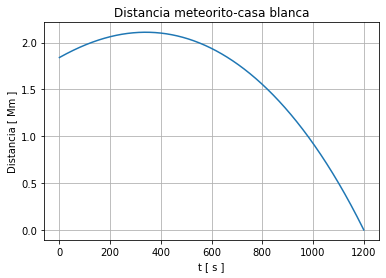

In [12]:
# Grafico de distancia meteorito-CasaBlanca vs tiempo
plt.plot(T,delta)
plt.title('Distancia meteorito-casa blanca')
plt.xlabel('t [ s ]')
plt.ylabel('Distancia [ Mm ]')
plt.grid()
plt.savefig('graph4.png', dpi=250)
plt.show()

**Coordenadas del punto de impacto**

In [13]:
# Matriz de anti-rotacion para poder encontrar el punto en Google Maps
Rimpacto = rotacion(rg,-T[-1])

# Transformacion (x,y,z)--> (lambda,psi)
Coordenadas=CT(Rimpacto)
Coordenadas

(38.897304670869076, -77.0366073137589)

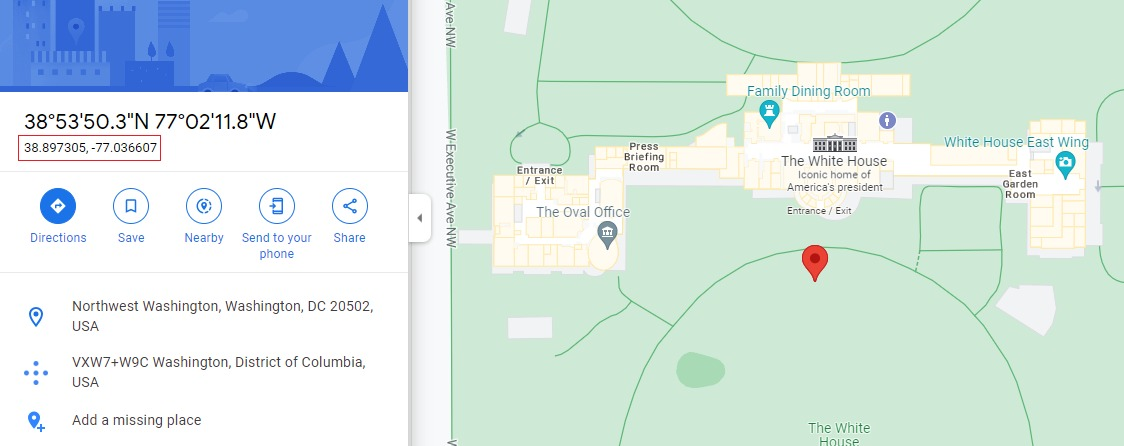

In [14]:
## ---- COORDENADAS DEL METEORITO -----

##Creamos una lista de listas
#coordenadas_meteorito = {'t':T,'Xmeteorito':Xg,'Ymeteorito':Yg,'Zmeteorito':Zg}

#Creamos un dataframe
#df_meteorito = pd.DataFrame(coordenadas_meteorito)

#Creamos un archivo csv de los datos obtenidos
#file = open('metcords2.dat',"x")

#Escribimos los datos obtenidos en el archivo creado
#df_meteorito.to_csv('metcords2.dat', sep =' ', index = False, header=False)

**Así luce la trayectoria del meteorito**

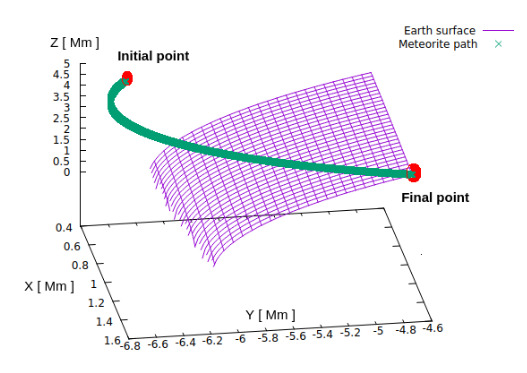

# Simulación 2 
## Problema Misil - Meteorito
El misil se lanza desde la universidad de Toronto, cuyas coordenadas son ( 43.662977° , -79.397759°  ), que en coordenadas cartesianas es:

$$
\vec{r}_0=(0.84891619,\ -4.5351625,\   4.40346754) \ Mm 
$$

El misil se lanza en direccion al punto objetivo $\vec{r}_p$ el cual es:

$$
\vec{r}_p=(1.0650870,\ -6.6195346,\  4.9331132)\ Mm
$$

Con una rapidez inicial de $v_0=0.01\ Mm/s$, es decir:

$$
\vec{v}_0=v_0\frac{\vec{r}_p-\vec{r}_0}{|\vec{r}_p-\vec{r}_0|}=(0.00100012,\ -0.0096434,\  0.00245042)\ Mm/s
$$



Los valores de los parametros requeridos son

$$
\beta=123\ kg/s \ \ , \ \ v_e=0.010\ Mm/s \ \ , \ \ m_{shell}=3,500\ kg
$$

$$
m_0=8,000\ kg \ \ , \ \ \mu=3.9861352 \times 10^{-4}\ Mm^2/kg\ s^2
$$

In [15]:
#Posicion inicial del misil
r0  = TC( 43.662977 , -79.397759 )    # Coords University of Toronto


#Punto objetivo
rp = np.array([ Xg[int(500/h)] , Yg[int(500/h)], Zg[int(500/h)]])

#Distancia relativa entre el misil y el punto objetivo
d0  = np.linalg.norm(rp-r0)

#Magnitud de la velocidad de eyeccion del combustible
u=0.010

#Velocidad inicial del misil
v0 = u*(rp-r0)/d0

print('r0=',r0)
print('v0=',v0)
print('rp=',rp)
print('v0=',v0)

r0= [ 0.84891619 -4.5351625   4.40346754]
v0= [ 0.00100012 -0.0096434   0.00245042]
rp= [ 1.06508701 -6.61953458  4.93311316]
v0= [ 0.00100012 -0.0096434   0.00245042]


Como ya se explicó en la teoría, existen tres etapas en el vuelo del misil
- Despegue
- Vuelo propulsado
- Vuelo libre

**1) Despegue**\
Al despegar el misil está montado sobre la superficie terrestre, la cual está rotando y esto produce una desviasión en su trayectoria al momento de perder contacto con el suelo, dicha desviasión viene incluida en la ecuación de movimiento:
$$
\frac{d^2\vec{r}}{dt^2}\Big|_R + 2\Big(\frac{d\vec{r}}{dt} \Big)_R\times \vec{\omega}+\vec{\omega}\times(\vec{\omega}\times\vec{r}) = \vec{g}+\frac{v_e \beta}{m_{shell}+m_{0}+ m_{man}-\beta t}\frac{\vec{r}_p-\vec{r}}{|\vec{r}_p-\vec{r}|}
$$

In [16]:
#DEFINIMOS LA FUNCION DE ACELERACION EN t=0 (Al momento del despegue)
def F0(r,rp,v,t,u):
  
  # Parametros importantes
  B=123 # kg/s
  mshell=3500 # kg
  m0=8000 # kg
  mu=3.98e-4 # Mm^3 / kg s^2
 # u=0.005 #Mm/s

  #Velocidad angular de la tierra
  w = np.array([ 0 , 0 , 7.2722052e-5 ])

  #Velocidad del misil en el marco no inercial
  vr = np.cross(w,v)

  # vector  w x r 
  p = np.cross(w,r)

  # vector unitario en direccion del movimiento
  vu = ( rp - r ) / np.linalg.norm( rp - r )


  # Funcion de masa
  m = mshell+m0-B*t

  # magnitud de los vetores de entrada
  nv = np.linalg.norm(v) 
  nr = np.linalg.norm(r) 
  
  # Aceleracion
  d2r = B * u * vu /  m  - mu * r / nr**3 -  2 * np.cross(vr,w) -  np.cross(w,p)

  return d2r

**2) Etapa de vuelo propulsado**

En esta etapa el misil ya perdió contacto con la tierra, por lo que se pueden referir las mediciones a un sistema de referencia inercial despreciando así el segundo y tercer termino del lado izquierdo de la ecuacion anterior. La ecuación de movimiento resulta:

$$
\ddot{\vec{r}}=\Big(\frac{\beta v_e}{m_{shell}+m_0+m_{man}-\beta t}\Big)\frac{\vec{r}_p-\vec{r}}{|\vec{r}_p-\vec{r}|}-\frac{\mu}{r^3}\vec{r}
$$

Sujeta a las condiciones iniciales 

$$
\vec{r}_0\ ^{new}=\vec{r}_0+ \vec{v}_0\ \delta t\
$$
&
$$
\vec{v}_0\ ^{new}=\vec{v}_0 + \ddot{\vec{r}}\ \delta t\
$$

Con $\delta t$ el intervalo de tiempo que tardo el misil en perder contacto con el suelo.

In [17]:
#DEFINIMOS LA FUNCIÓN DE ACELERACION PARA T>0.
def F(r,rp,v,t,u):
  
  # Parametros importantes
  B=123 # kg/s
  mshell=3500 # kg
  m0=8000 # kg
  mu=3.98e-4 # Mm^3 / kg s^2
  #u=0.005 #Mm/s

  #Velocidad angular de la tierra
  w = np.array([ 0 , 0 , 7.2722052e-5 ])

  #Velocidad del misil en el marco no inercial
  vr = np.cross(w,v)

  # vector  w x r 
  p = np.cross(w,r)

  # vector unitario en direccion del movimiento
  vu = ( rp - r ) / np.linalg.norm( rp - r )


  # Funcion de masa
  m = mshell+m0-B*t

  # magnitud de los vetores de entrada
  nv = np.linalg.norm(v) 
  nr = np.linalg.norm(r) 
  
  # Aceleracion
  d2r = B * u * vu /  m   - mu * r / nr**3 

  return d2r

**Las ecuaciones de movimiento se resuelven usando el método Runge Kutta 4**

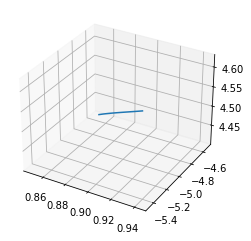

In [18]:
B  = 123 # kg/s
m0 = 8000 # kg

#Tiempo de propulsion
tp = m0 / B
h = 0.01

#Listas de coordenadas
Xm=[ r0[0] ] ; Ym=[ r0[1] ] ; Zm=[ r0[2] ] ; R=[np.linalg.norm(r0)]
Vx=[ v0[0] ] ; Vy=[ v0[1] ] ; Vz=[ v0[2] ] ; V=[np.linalg.norm(v0)] 
tiempo=[0] 

#--------------- Estado 1 ------------------
v = v0 ; r = r0 ; t=h
v = v + F0(r0,rp,v0,t,u)*h
r = r + v*h

Xm.append(r[0])  ;  Vx.append(v[0])
Ym.append(r[1])  ;  Vy.append(v[1])
Zm.append(r[2])  ;  Vz.append(v[2])

tiempo.append(t)
V.append( np.linalg.norm(v) ) 
R.append( np.linalg.norm(r))
# ------------ Estado t > 1 ----------------

t=2*h

while t <= tp:

  l1 = h * F(r,rp,v,t,u)
  k1 = h * v
  l2 = h * F(r+0.5*k1,rp,v+0.5*l1,t+0.5*h,u)
  k2 = h * ( v + 0.5 * l1 )
  l3 = h * F(r+0.5*k2,rp,v+0.5*l2,t+0.5*h,u)
  k3 = h * ( v + 0.5 * l2 )
  l4 = h *  F(r+k3,rp,v+l3,t+h,u)
  k4 = h * ( v + l3 )

  v = v + 1.0/6.0 * ( l1 + 2*l2 + 2*l3 + l4 )
  r = r + 1.0/6.0 * ( k1 + 2*k2 + 2*k3 + k4 )

  Xm.append(r[0])  ;  Vx.append(v[0])
  Ym.append(r[1])  ;  Vy.append(v[1])
  Zm.append(r[2])  ;  Vz.append(v[2])

  tiempo.append(t)
  V.append( np.linalg.norm(v) )  
  R.append( np.linalg.norm(r) )
  t+=h 

# Creamos la figura
fig = plt.figure()

# Agrrgamos un plano 3D
ax1 = fig.add_subplot(111,projection='3d')

# Datos en array bi-dimensional
x = np.array([Xm])
y = np.array([Ym])
z = np.array([Zm])

# plot_wireframe nos permite agregar los datos x, y, z. Por ello 3D
# Es necesario que los datos esten contenidos en un array bi-dimensional
ax1.plot_wireframe(x, y, z)

# Mostramos el gráfico
plt.show()

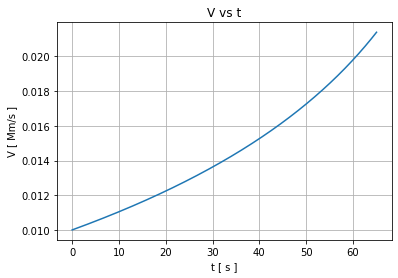

Rapidez inicial:  0.01 Mm/s
Rapidez final  :  0.021394858666144368 Mm/s
------------------------------


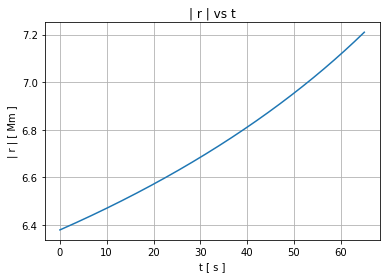

R inicial:  6.378 Mm
R final  :  7.210156769113917 Mm


In [19]:
#Velocidad vs tiempo
plt.plot(tiempo,V)
plt.title('V vs t')
plt.xlabel('t [ s ]')
plt.ylabel('V [ Mm/s ]')
plt.grid()
plt.savefig('graph4.png', dpi=250)
plt.show()

print('Rapidez inicial: ',V[0],'Mm/s')
print('Rapidez final  : ',V[-1],'Mm/s')
print('------------------------------')

#Distancia radial vs tiempo
plt.plot(tiempo,R)
plt.title('| r | vs t')
plt.xlabel('t [ s ]')
plt.ylabel('| r | [ Mm ]')
plt.grid()
plt.savefig('graph4.png', dpi=250)
plt.show()

print('R inicial: ',R[0],'Mm')
print('R final  : ',R[-1],'Mm')

**3) Etapa de vuelo libre**

Cuando se termina el combustible, la ecuacion de movimiento es

$$
\ddot{\vec{r}}=-\frac{\mu}{r^3}\vec{r}
$$

Y las condiciones iniciales $\vec{r}_0$ y $\vec{v}_0$ son las $\vec{r}_f$ y $\vec{v}_f$ de la etapa de vuelo propulsado.

**Problema de Lambert del misil**

- Recien mencionamos que $\vec{r}_1$ es la ultima posición del misil en la etapa anterior. 
- Elegimos además $\vec{r}_p$ como nuestro $\vec{r}_2$ 
-  El tiempo de vuelo $\Delta t$, se define como:

$$
\Delta t=500-t' 
$$
$$
t'=Tiempo\ que\ duro\ la\ etapa\ de\ vuelo\ propulsado
$$

En este caso $t'=65s$ por lo que $\Delta t=435s$

In [20]:
#Estado final del vuelo propulsado:
r0 = r  ;  nr0 = np.linalg.norm(r0)   
v0 = v  ;  nv0 = np.linalg.norm(v0)

#Posicion inicial del misil
r1=r0 ; v0old=v0

#Se elige el punto de impacto como la posicion del meteorito en t=500
r2=np.array([ Xg[int(500/h)] , Yg[int(500/h)] , Zg[int(500/h)] ])

# TIEMPO DE VUELO: 
# el tiempo que le toma al meteorito llegar a ese punto menos lo que ya
# transcurrio el misil, esto es: 500 segundos-65 Segundos = 435 segundos
dt=500-tp

#Constante mu [ km^2 / s^3 ]
mu=3.98e-4 

print('r1=',r1)
print('r2=',r2)
print('v0=',v0)

r1= [ 0.94263767 -5.44908851  4.62657857]
r2= [ 1.08252921 -6.60384201  4.93400306]
v0= [ 0.00211762 -0.02069063  0.00501532]


**Ahora que conocemos $\vec{r}_1$ , $\vec{r}_2$ y $\Delta t$ tenemos todo para determinar $\vec{v}_1$**

La forma de hacerlo sera repitiendo el proceso anterior, calculamos $\vec{v}_1$ resolviendo el problema de lambert.

In [21]:
import time

start = time.time()

# 1) calculamos r1 y r2
nr1=np.linalg.norm(r1)
nr2=np.linalg.norm(r2)

# 2) Calculamos delta theta
k  = np.array([0,0,1])
r3 = np.cross(r1,r2)
rz = r3 @ k

if rz < 0:
  dtheta = math.acos( r1 @ r2 / ( nr1 * nr2 ))
else:
  dtheta = 2*np.pi-math.acos( r1 @ r2 / ( nr1 * nr2 ) )

# 3) Calculamos A
A = np.sin(dtheta)*math.sqrt( nr1 * nr2 / (1-np.cos(dtheta)))

# 4) Definimos las funciones S(z), C(z), S'(z), C'(z), y(z), y'(z), F(z) y F'(z)

# Funcion S(z)
def S(x): 
  y=0
  for n in range(8):
    y+=(-1)**n*x**n/math.factorial(2*n+3)
  return y

#Funcion S'(z)
def dS(x):
  y=0
  for n in range(8):
    y+=(-1)**(n+1) * ( n + 1 ) * x**n /math.factorial(2*n+5)
  return y

# Funcion C(z)
def C(x):
  y=0
  for n in range(8):
    y+=(-1)**n * x**n /math.factorial(2*n+2)
  return y 

# Funcion C'(z)
def dC(x):
  y=0
  for n in range(8):
    y+=(-1)**(n+1)*(n+1)*x**n/math.factorial(2*n+4) 
  return y

y = lambda x: nr1 + nr2 + A * ( x*S(x) - 1 ) / C(x)**0.5

dy = lambda x: A/4*C(x)**0.5 

F  = lambda x: (y(x)/C(x))**1.5 *  S(x) + A*y(x)**0.5 - mu**0.5 * dt

dF = lambda x: 0.5/(y(x)*C(x)**5)**(0.5) * ( (2*C(x)*dS(x) - 3*dC(x)*S(x))*y(x)**2 + (A*C(x)**2.5+3*C(x)*S(x)*y(x))*dy(x)  ) 

#Metodo de Newton Raphson
zr=NR(1,F,dF)

# 6) Usamos el valor de z para evaluar las funciones f, g y dg
yz=y(zr)
f=1-yz/nr1
g=A*(yz/mu)**0.5
dg=1-yz/nr2 

# Calculamos la velocidad inicial
v1=1/g*(r2-f*r1)
print('La velocidad inicial que cumple el problema de Lambert es:')
print('v1=',v1,'Mm/s')
print()
print('La maniobra requirio el siguiente dv:')
Vec_dv=v1-v0
dv=np.linalg.norm(v1-v0old)
print('dv=',Vec_dv,'Mm/s')
print()
print('Cuya magnitud es:')
print('|dv|=',dv*1000,'km/s')

grav=mu/8.31489**2
MassRate=1-math.exp(-0.001/grav/455)
MassRate



print()
print('la porcion de masa empleada en la maniobra fue:')
print(MassRate/0.01,'% de la masa actual')

end = time.time() 

tc = end - start 
print()
print('El tiempo de computo requerido por el algoritmo de Lambert fue')
print(round(tc,5)*1000,'Mili-segundos')
print()
print('El incremento porcentual en la velocidad causado por la maniobra fue')
print(dv/np.linalg.norm(v0)*100,'%')

La velocidad inicial que cumple el problema de Lambert es:
v1= [ 0.00051418 -0.0037889   0.00162901] Mm/s

La maniobra requirio el siguiente dv:
dv= [-0.00160344  0.01690174 -0.00338631] Mm/s

Cuya magnitud es:
|dv|= 17.31204195069177 km/s

la porcion de masa empleada en la maniobra fue:
31.735800633557677 % de la masa actual

El tiempo de computo requerido por el algoritmo de Lambert fue
12.0 Mili-segundos

El incremento porcentual en la velocidad causado por la maniobra fue
80.9168325009161 %


**Maniobra Orbital**\
Ahora que conocemos $\vec{v}_1$ tenemos el problema de Lambert practicamente resuelto, salvo porque la velocidad inicial real del misil es $\vec{v}_0$. 

La manera de convertir $\vec{v}_0$ en $\vec{v}_1$ es mediante una maniobra, es decir una eyeccion rapida de compustible que cambie la direccion y magnitud de la velocidad del cohete, matematicamente esto es:
$$
\vec{v}_1=\vec{v}_0+\Delta\vec{v}
$$

Como conovemos $\vec{v}_0$ y $\vec{v}_1$ solo hacemos
$$
\Delta\vec{v}=\vec{v}_1-\vec{v}_0
$$

De tal modo que, la forma de justificar un cambio repentino en la velocidad del misil es la siguiente:
$$
\vec{v}_1=\vec{v}_0+(\vec{v}_1-\vec{v}_0)
$$

In [22]:
print('Las condiciones iniciales son entonces:')
print('r1=',r1)
print('v1=',v1)

Las condiciones iniciales son entonces:
r1= [ 0.94263767 -5.44908851  4.62657857]
v1= [ 0.00051418 -0.0037889   0.00162901]


**Etapa de vuelo libre**

In [23]:
# Magnitud del momento angular
H=np.cross(r1,v1)
h=np.linalg.norm(H)

# Base canonica
k=np.array([0,0,1]) ; i_=np.array([1,0,0]) ; j=np.array([0,1,0])

# Vector nodo
N=np.cross(k,H)
n=np.linalg.norm(N)

# Exentricidad
ex = np.cross(v1,H) / mu -  r1 / nr1
e=np.linalg.norm(ex)
e

# Calculamos los vectores base en el sistema perifocal
xp=ex/e
zp=H/h
yp=np.cross(zp,xp)
e

# Semi-eje mayor "a"
p=h**2/mu
a=p/(1-e**2)

**Parametrización de la órbita**

In [24]:
def fg2(a,r1,nr1,v1,mu):

  # Funcion S(z) 
  def S(x): 
    y=0
    for n in range(8):
      y+=(-1)**n*x**n/math.factorial(2*n+3)
    return y

  # Funcion C(z)
  def C(x):
    y=0
    for n in range(8):
      y+=(-1)**n * x**n /math.factorial(2*n+2)
    return y 

  # Coeficientes necesarios en la ecuacion trascendente
  alpha=1/a ; pp=np.dot(r1,v1) ; rmu=math.sqrt(mu) ; Dt=0.01

  F  = lambda x: np.dot(r1,v1)/math.sqrt(mu)*x**2*C(alpha*x**2)+(1-alpha*nr1)*x**3*S(alpha*x**2)+nr1*x-math.sqrt(mu)*Dt

  dF = lambda x: np.dot(r1,v1)/math.sqrt(mu)*x *(1-alpha*x**2*S(alpha*x**2))+(1-alpha*nr1)*x**2*C(alpha*x**2)+nr1

  #Solucion de la ecuacion de Kepler mediante Newton-Raphson
  x0=math.sqrt(mu)*alpha*Dt
  xold=x0
  tol=1e-8
  dx=abs(2*tol)

  while dx > tol:
    xnew=xold-F(xold)/dF(xold)
    dx=abs(xnew-xold)
    xold=xnew
  xnew

  #Calculo de f y g 
  f=1-xnew**2/nr1*C(alpha*xnew**2)
  g=Dt-xnew**3/math.sqrt(mu)*S(alpha*xnew**2)
  
  r2=r1*f+v1*g ; nr2=np.linalg.norm(r2)

  df=math.sqrt(mu)/nr1/nr2*(alpha*xnew**3*S(alpha*xnew**2)-xnew)
  dg=1-xnew**2/nr2*C(alpha*xnew**2)

  v2=df*r1+dg*v1 

  return r2,v2

# Calculamos la trayectoria
s=0 ; v=v1 ; r=r1 ; nr1 = np.linalg.norm(r1)
Xf=[ r1[0] ] ; Yf=[ r1[1] ] ; Zf=[ r1[2] ]; T=[0]
Vx=[v[0]] ; Vy=[V[1]] ; Vz=[v[2]]

while s<dt:
  fg=fg2(a,r1,nr1,v1,mu)
  Xf.append(fg[0][0]) ; Yf.append(fg[0][1]) ; Zf.append(fg[0][2])
  Vx.append(fg[1][0]) ; Vy.append(fg[1][1]) ; Vz.append(fg[1][2])
  T.append(s)
  r1=fg[0] ; nr1=np.linalg.norm(r1) ;v1=fg[1]
  s+=0.01

rf=np.array([Xf[-1],Yf[-1],Zf[-1]])


print('la posicion final es:')
print('rf=',rf,'Mm')
print('r2=',r2,'Mm')
print()
print('Error:')
print(np.linalg.norm(rf-r2)*1e6,'Metros')
print()
altura = np.linalg.norm(rf)-6.378
print('La altura a la que ocurrio el encuentro fueron:')
print(altura*1000,'Km sobre la superficie terrestre')

la posicion final es:
rf= [ 1.0825293  -6.60384305  4.93400299] Mm
r2= [ 1.08252921 -6.60384201  4.93400306] Mm

Error:
1.0513752106926864 Metros

La altura a la que ocurrio el encuentro fueron:
1936.2647441908437 Km sobre la superficie terrestre


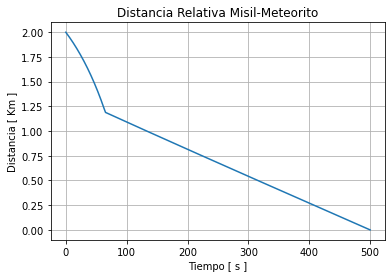

Distancia minima= 1.0513752106926864 metros


In [25]:
# Para evitar repeticiones en el ultimo y primer elemento al concatenar las listas de coordenadas de la etapa de vuelo
# Propulasdo y vuelo libre usamos el comando "pop", este comando elimina el ultimo elemento de una lista.
Xm.pop(-1) ; Ym.pop(-1) ; Zm.pop(-1)

#Coordenadas misil
Xmisil=Xm+Xf  ; Ymisil=Ym+Yf  ; Zmisil=Zm+Zf 

#Coordenadas del meteorito
Xmeteorito=[] ; Ymeteorito=[] ; Zmeteorito=[]

for i in range(len(Xmisil)):
  x=Xg[i] ; y=Yg[i] ; z=Zg[i]
  Xmeteorito.append(x)
  Ymeteorito.append(y)
  Zmeteorito.append(z)
    
Dx=np.array(Xmeteorito)-np.array(Xmisil)  
Dy=np.array(Ymeteorito)-np.array(Ymisil)  
Dz=np.array(Zmeteorito)-np.array(Zmisil)
D=(Dx**2+Dy**2+Dz**2)**0.5 
tiempo_ = np.linspace(0,500,len(D))
plt.plot(tiempo_,D)
plt.title('Distancia Relativa Misil-Meteorito')
plt.ylabel('Distancia [ Km ]')
plt.xlabel('Tiempo [ s ]')
plt.grid()
plt.savefig('graph5.png', dpi=250)

plt.show()

#Rmisil=np.array([Xmisil[500],Ymisil[500],Zmisil[500]]) ; Rmeteorito=np.array([Xmeteorito[500],Ymeteorito[500],Zmeteorito[500]])
#Rmisil,Rmeteorito
print('Distancia minima=',min(D)*1e6,'metros')

**Exportamos coordenadas para graficar en GnuPlot**

In [ ]:
## ---- COORDENADAS DEL METEORITO -----

##Creamos una lista de listas
#coordenadas_meteorito = {'Xmeteorito':Xmeteorito,'Ymeteorito':Ymeteorito,'Zmeteorito':Zmeteorito}

#Creamos un dataframe
#df_meteorito = pd.DataFrame(coordenadas_meteorito)

#Creamos un archivo csv de los datos obtenidos
#file = open('CoordsMet.dat',"x")

#Escribimos los datos obtenidos en el archivo creado
#df_meteorito.to_csv('CoordsMet.dat', sep =' ', index = False, header=False)


## ----- COORDENADAS DEL MISIL -----

#Creamos lista de listas
#coordenadas_misil = {'Xmisil':Xmisil,'Ymisil':Ymisil,'Zmisil':Zmisil}

#Creamos el DataFrame
#df_misil = pd.DataFrame(coordenadas_misil)

#Creamos un archivo csv de los datos obtenidos
#file = open('CoordsMis.dat',"x")

#Escribimos los datos obtenidos en el archivo creado
#df_misil.to_csv('CoordsMis.dat', sep =' ', index = False, header=False)

**Así lucen las trayectorias**

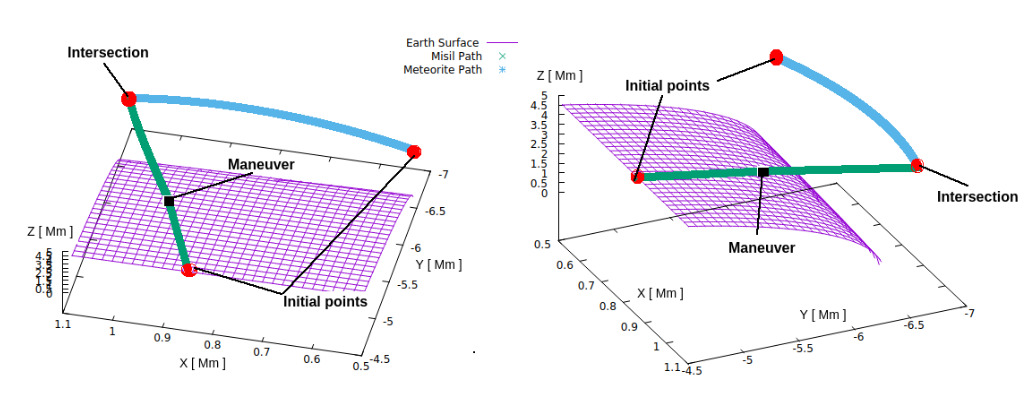